In [40]:
# Notebook for computing CLVs of the Lorenz 63 system
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt 
from scipy.integrate import odeint
from scipy.linalg import expm
from mpl_toolkits.mplot3d import Axes3D

In [41]:
# First we solve and plot L63

In [42]:
# L63 Definition

#Parameters
a = 10.0
b = 8/3
c = 28.0

def L63(state, t, a=10.0, b=8/3, c=28.0):
    """ ODEs defining Lorenz 63 system.
    Parameter, state: current state.
    Parameter, t: time.
    Option, a: integer, parameter.
    Option, b: integer, parameter.
    Option, c: integer, parameter.
    """
    x, y, z = state
    dxdt = a * (y - x)
    dydt = (c * x) - y - (x * z)
    dzdt = (x * y) - (b * z)
    dudt = np.array([dxdt, dydt, dzdt])
    return dudt


In [90]:
# Time Parameters

dt = 0.01 # Time step 
k = 3 # Number of steps that 'the propagator' moves you forward
transient = 0
stepsA = 4 * k # Controls convergence to BLVS
stepsB = 1 * k # Number of points we want CLVs at
stepsC = 1 * k # Controls convergence of A- matrix, (coefficients of CLVs in BLV basis)
steps = stepsA + stepsB + stepsC + transient # Number of steps
time = np.arange(0, steps * dt, dt)
print(time)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17]


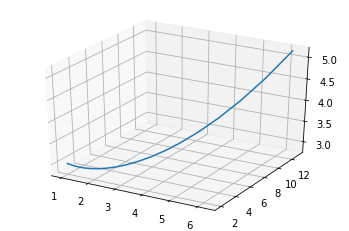

(18, 3)


In [96]:
# Solving L63

IC = np.array([1.0, 2.0, 3.0]) 
solution = odeint(L63, IC, time)

# Plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(solution[:, 0], solution[:, 1], solution[:, 2])
plt.show()
print(solution.shape)

In [92]:
# Jacobian Matrix

def Jacobian(location, parameters):
    """Returns the jacobian matrix at a given point of L63.
    Param, location, array: [x, y, z] coordinates.
    Parameters, parameters, L63 parameters.
    """
    [a, b, c] = parameters
    [x, y, z] = location
    row1 = np.array([-a, a, 0])
    row2 = np.array([c - z, -1, -x])
    row3 = np.array([y, x, -b])
    J = np.array([row1, row2, row3])
    return J

# Test of Jacobian Function
# location = [2, 0, 1]
# print(Jacobian(location, [a, b, c]))

In [93]:
# Making a Time Series of the Jacobians
# Note that J(step * dt) = Jacobians[:, :, step]

jacobians = np.zeros((3, 3, time.shape[0])) # Time series of Jacobian matrix. Indexed as (row, column, step)
for t in range(time.shape[0]):
    #print(f'Solution to Lorenz at step {t} {solution[t, :]}\n\n')
    #print(f'Jacobian at this step is {Jacobian(solution[t, :], [a, b, c])}\n\n')
    jacobians[:, :, t] = Jacobian(solution[t, :], [a, b, c])
    #print(f' Stored Jacobian is {jacobians[:, :, t]}\n\n')
    
print(jacobians.shape)

(3, 3, 18)


In [94]:
# Propagator

def Propagator(step, k, jacobians):
    """ Propagator matrix F(step, step + k). Evolves solutions of TLE forward in time.
    Param, step, integer: step we're caluclating propator at
    Param, k, how many steps we push forward.
    """
    F = jacobians[:, :, step]
    #print(f'At step {step} the jacobian is\n {jacobians[:, :, step]}.\n\n')
    for i in range(1, k):
        #print(f'At step {step + i} the jacobian is\n {jacobians[:, :, step + i]}.\n\n')
        F = np.dot(F, jacobians[:, :, step + i])
    return F

# k = 3
# step = 1
# print(Propagator(step, k, jacobians))
# Jk = jacobians[:, :, step]
# Jk1 = jacobians[:, :, step + 1]
# Jk2 = jacobians[:, :, step + 2]
# print(reduce(np.dot, [Jk, Jk1, Jk2]))

In [75]:
# Implementing the Ginelli Algorithm

In [89]:
# Function to ensure QR decomposition has positive diagonals

def posQR(M):
    """ Returns QR decomposition of a matrix with positive diagonals on R.
    Parameter, M: Array that is being decomposed
    """
    Q, R = np.linalg.qr(M) # Performing QR decomposition
    signs = np.diag(np.sign(np.diagonal(R))) # Matrix with signs of R diagonal on the diagonal
    Q, R = np.dot(Q, signs), np.dot(signs, R) # Ensuring R Diagonal is positive
    return Q, R

A = np.identity(3)
A[0, 0] = -1
A[0, 1] = 3
A[2, 2] = 2
print(A)
#Q, R = np.linalg.qr(A)
Q, R = posQR(A)
print(Q)
print(R)

[[-1.  3.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  2.]]
[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]
[[ 1. -3.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  2.]]


In [ ]:
# Calculating Lyapunov Spectrum

Qs = np

In [76]:
# Storage
Qs = np.zeros((3, 3, int(stepsB/k)))
print(Qs.shape)
Rs = Qs
Rs2 = np.zeros((3, 3, int(stepsC/k)))
CLVs = Qs
FTLE = np.zeros((int(stepsB/k), 3))

(3, 3, 4)


In [78]:
# Step 1: Getting the BLVs & LEs

# Bennetin Stepping

M0 = np.identity(3) # Take identity matrix as initial condition for matrix equation
oldM = M0 #Initialising oldQ
for i in range(0, stepsA, k):
    F = Propagator(i, k, jacobians) # Propagator pushing k steps forward from i
    M = np.matmul(F, oldM) # Pushing dynamics forward
    Q, R = np.linalg.qr(M) # Performing QR decomposition
    signs = np.diag(np.sign(np.diagonal(R))) # Matrix with signs of R diagonal on the diagonal
    Q, R = np.dot(Q, signs), np.dot(signs, R) # Ensuring R diagonal is positive
    oldM = Q
    if i in range(stepsA - (8 * k), stepsA): # Print statement to check convergence
        print(f'After {i} steps.\n')
        print(f'Q is: \n\n {Q}\n\n')
        print(f'R is: \n\n {R}\n') # In case you want to check R's also

After 0 steps.

Q is: 

 [[-0.57033421  0.81730599  0.08203545]
 [ 0.82050026  0.56214623  0.10378311]
 [ 0.03870664  0.12650117 -0.991211  ]]


R is: 

 [[11037.8233013  -4531.57414092  -355.16559912]
 [    0.          1245.05944493   -48.13297345]
 [    0.             0.            16.01657977]]

After 3 steps.

Q is: 

 [[ 0.64775761  0.75380696 -0.11038634]
 [-0.76093096  0.63305056 -0.14223593]
 [-0.0373383   0.1761308   0.98365837]]


R is: 

 [[10162.40190796 -6382.35598216  -902.8597342 ]
 [    0.          1330.766028     285.91630022]
 [    0.             0.            13.89627107]]

After 6 steps.

Q is: 

 [[-0.63668777  0.75579661  0.15297112]
 [ 0.76912531  0.60815347  0.19645767]
 [ 0.05545213  0.24273615 -0.96850618]]


R is: 

 [[ 1.08019590e+04  5.34948747e+03 -1.22621210e+03]
 [ 0.00000000e+00  1.20352295e+03 -3.67400747e+02]
 [ 0.00000000e+00  0.00000000e+00  9.98698650e+00]]

After 9 steps.

Q is: 

 [[ 0.63643311  0.74094364 -0.21437212]
 [-0.76752281  0.58075399 -

[269.69908821 198.50168729 155.74033772]


ValueError: x and y must have same first dimension, but have shapes (16000,) and (1000,)

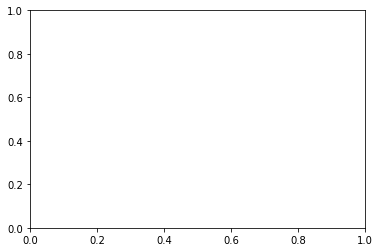

In [14]:
# Step 2: More Benettin steps
# Store both BLVs and R's.
# Also Computing LE

oldM = Q #Initialising
for i in range(0, stepsB, k):
    j = int(i/k) # Index for storage
    F = Propagator(stepsA + i, k, jacobians) # Propagator
    M = np.matmul(F, oldM) # Pushing dynamics forward
    Q, R = np.linalg.qr(M) # Performing QR decomposition
    signs = np.diag(np.sign(np.diagonal(R))) # Matrix with signs of R diagonal on the diagonal
    Q, R = np.dot(Q, signs), np.dot(signs, R) # Ensuring R diagonal is positive
    FTLE[j] = np.log(np.diagonal(R))/(dt * k)
    Qs[:,:, j], Rs[:, :, j] = Q, R
    oldM = Q
    
#     if i in range(stepsB - (8 * k), stepsB): # Print statement to check convergence
#         print(f'After {i} steps.\n')
#         print(f'FTLEs are {FTLE[j]}\n\n')
#         print(f'Q is: \n\n {Q}\n\n')
#         print(f'R is: \n\n {R}\n') # In case you want to check R's also

print(np.mean(FTLE, axis = 0))
FTLE.shape[0]
plt.plot(time, FTLE[:, 0])
plt.show()

In [164]:
# Step 3: More Benettin steps
# Now we stores R's only. 

oldM = Qs[:,:, int(stepsB/k) - 1] #Initialising oldM
for i in range(0, stepsC, k):
    j = int(i/k) # Index for storage
    F = Propagator(stepsA + stepsB + i, k, jacobians) # Propagator
    M = np.matmul(F, oldM) # Pushing dynamics forward
    Q, R = np.linalg.qr(M) # Performing QR decomposition
    Rs2[:, :, j] =  R
    oldM = Q

In [165]:
# Step 4: Time to go back, converging to A- matrix

# Initialise an upper triangular matrix
A = 3 * np.triu(M0)
A[0,1] =1

# We will evolve upper triangular matrix backward to timeB using the stored R's from Step 3
# This should converge to 'A-' of QR decomposition of CLVs "Gamma = phi^- A-"

oldA = A
for i in range(0, stepsC, k):
    
    j = int(i/k)
    
    # Normalises A's to prevent overflow
    norms = np.linalg.norm(oldA, axis=0, ord=2) # L2 of column norms
    oldA = oldA/norms
    
    # Pushing A- backwards with R's
    Rinv = np.linalg.inv(Rs2[:, :, int(stepsC/k) - j - 1])
    newA = np.matmul(Rinv, oldA)
    oldA = newA

In [168]:
# Step 5: Keep going back, finding CLVs

oldA = Aminus

for i in range(0, stepsB, k):
    
    j = int(i/k)
    
    # Pushing A- backwards with R's
    Rinv = np.linalg.inv(Rs[:, :, int((stepsB)/k) - j - 1])
    newA = np.matmul(Rinv, oldA)
    
    # Calculating FTCLE
    oldBLV = Qs[:,:, int((stepsB)/k) - j - 1]
    oldCLV = np.matmul(oldBLV, oldA)
    oldSize = np.linalg.norm(oldCLV, axis=0, ord=2)
    newBLV = Qs[:,:, int((stepsB)/k) - j - 2]
    newCLV = np.matmul(BLV, newA)
    newSize = np.linalg.norm(newCLV, axis=0, ord=2)
    #print(f'Fintie lyapunov exponents are {np.log(oldSize/newSize)}\n\n')
    FTCLE[int((stepsB)/k) - j - 1] = (np.log(oldSize/newSize))/k
    
    # Normalise A-'s to prevent overflow
    norms = np.linalg.norm(newA, axis=0, ord=2) # L2 of column norms
    #print(f'Fintie lyapunov exponents are {np.log(norms)}\n\n') #L.E.'s
    #FTCLE[j, :] = np.log(norms)
    newA = newA/norms 
    
    # Calculate CLV, using A- and BLV
    BLV = Qs[:,:, int((stepsB)/k) - j - 1]
    CLVs[:, :, int((stepsB)/k) - j - 1] = np.matmul(BLV, newA)
    
    oldA = newA


In [171]:
# Averaging FTCLEs
print(np.mean(FTCLE, axis = 0))


[2.7028983  1.90990577 1.4463587 ]
